# Facebook Messenger Analytics
I've always been interested in applying my data analytics skills on my own personal life. I'm curious to see how well I know myself and my friends, and if there are underlying patterns that I can uncover through digginng through my own data. Are there trends I didn't know about? How have my speech patterns changed as I moved across high school, college, work, and grad school? Has my vocabulary expanded or contracted at certain points? I'll try to answer these questions and others in the analysis found here. 

_Note: Due to the deeply personal nature of this data, I've kept the raw data off of Github and obscured any personally identifiable information._

Contents:
* Loading Data & Initial Exploration
* Feature Engineering
    * Basic Features
    * Sentiment Scoring
    * Profanity Identification
* Data Visualizations
    * Content Types
    * Trends over Time
    * Example Friend Analysis
* Aggregated Analyses
    * By Sender

## Loading Data & Initial Exploration
Loading data obtained through Facebook's "Download your Information" feature. Each thread (group chats and direct messages) was combined into a single CSV file used here. For additional information on how to pull your own data, click [here](https://www.facebook.com/help/1701730696756992). 

In [3]:
import pandas as pd
pd.set_option('display.max_columns', None)

In [2]:
data = pd.read_csv("C:/Users/aliya/Documents/Side Projects/Facebook/Cleaned_messages.csv")

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (5,15,16,18,20) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
data.drop(['sender_name', 'content', 'participants', 'users'], axis = 1).head() # Hiding sender name, thread name, and message contents

,Unnamed: 0,timestamp_ms,type,sticker,title,is_still_participant,thread_type,thread_path,photos,share,reactions,files,ip,call_duration,missed,gifs,audio_files,videos
0,0,1485302620404,Unsubscribe,NaN,36303 group,False,RegularGroup,archived_threads/36303group_pgmwn-_5fa,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1485297599245,Generic,NaN,36303 group,False,RegularGroup,archived_threads/36303group_pgmwn-_5fa,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,1485292477100,Generic,{'uri': 'messages/stickers_used/39178562_15051...,36303 group,False,RegularGroup,archived_threads/36303group_pgmwn-_5fa,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,1485292467803,Generic,NaN,36303 group,False,RegularGroup,archived_threads/36303group_pgmwn-_5fa,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,1485292439211,Generic,{'uri': 'messages/stickers_used/851587_3692393...,36303 group,False,RegularGroup,archived_threads/36303group_pgmwn-_5fa,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
data.shape # Number of rows and columns

(613195, 22)

Each message is attached to a sender ("sender_name" column) and a thread ("participants" column). In 1-on-1 chats, the thread is just the name of myself and the person I am messaging. In groupchats, the thread is a list of all participants in the chat. For example, if I was just DM'ing Scooby Doo, the sender might be "Scooby Doo", and the thread might be "Scooby Doo, Aliya Zee". However, if I was in a group chat with the whole gang, the sender could be anyone from the gang (depending on who sent the message) and the thread would be "Aliya Zee, Scooby Doo, Shaggy, Daphne, Velma, Fred". 

I obscure these for privacy reasons below.

In [5]:
# Obscuring sender_name from the name of the sender to their rank in total messages
# I am Sender_0, and my top friends are therefore Sender_1, Sender_2, etc.
name_key = pd.DataFrame(data.value_counts('sender_name')).reset_index().reset_index()
name_key.columns = ['sender_name_code', 'sender_name', 'sender_count']
name_key['sender_name_code'] = "Sender_" + name_key['sender_name_code'].astype('str')
data = pd.merge(data, name_key, on = 'sender_name', how = 'left')

# Obscuring participants from the name of the participants list to their rank in total messages
# My longest thread is Thread_0, second-longest is Thread_1, etc.
thread_key = pd.DataFrame(data.value_counts('participants')).reset_index().reset_index()
thread_key.columns = ['participants_code', 'participants', 'participants_count']
thread_key['participants_code'] = "Thread_" + thread_key['participants_code'].astype('str')
data = pd.merge(data, thread_key, on = 'participants', how = 'left')

In [6]:
# Creating a clearer column for filtering messages I send vs the ones I receive
data['Direction'] = "Received"
data.loc[data['sender_name_code'] == "Sender_0", 'Direction'] = "Sent"

## Feature Engineering
Creating additional features to enable deeper analysis.
### Basic Features

In [7]:
# Creating aggregated date columns
data['Datetime'] = pd.to_datetime(data['timestamp_ms'], unit = 'ms')
data['Date'] = data['Datetime'].dt.date
data['Year-Month'] = data['Datetime'].values.astype('datetime64[M]')

import numpy as np
# Creating a column counting the number of characters used
data['Text_length'] = data['content'].str.len()
# Messages with a call/subscribe type contain standardized sentences in the "content" column. These get cleared to NA values
data.loc[data['type'].isin(['Call', 'Subscribe', 'Unsubscribe']), 'Text_length'] = np.NaN

# Adding simple T/F columns for emoji. Future analysis could include proper emoji as well.
data['emoji_happy'] = data['content'].str.contains(':)', regex = False, na = False)
data['emoji_sad'] = data['content'].str.contains(':(', regex = False, na = False)
data['emoji_xD'] = data['content'].str.contains('xD', regex = False, na = False) # We all make mistakes

# Identifying groupchats
data['groupchat'] = (data['thread_type'] == 'RegularGroup')

In [8]:
# Dropping a filler column, the original timestamp, unused threadtype and ip (only my ip was included)
data.drop(['Unnamed: 0', 'timestamp_ms', 'ip', 'thread_type'], axis = 1, inplace = True)

In [9]:
data.loc[data['type'] == 'Subscribe', 'content'] = ""
data.loc[data['type'] == 'Unsubscribe', 'content'] = ""

### Sentiment Scoring
Using VaderSentiment to identify positive, negative, neutral, and compound sentiment scores for each message. To clarify the meaning of these scores, please reference the following definitions found [here](https://github.com/cjhutto/vaderSentiment).

> The pos, neu, and neg scores are ratios for proportions of text that fall in each category (so these should all add up to be 1... or close to it with float operation). These are the most useful metrics if you want multidimensional measures of sentiment for a given sentence.

> The compound score is computed by summing the valence scores of each word in the lexicon, adjusted according to the rules, and then normalized to be between -1 (most extreme negative) and +1 (most extreme positive). This is the most useful metric if you want a single unidimensional measure of sentiment for a given sentence. Calling it a 'normalized, weighted composite score' is accurate.

In [10]:
import nltk
from nltk.corpus import stopwords
stop_words=stopwords.words('english')

In [11]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer 
sid = SentimentIntensityAnalyzer()

In [12]:
data['content'] = data['content'].fillna('')
data['content_clean'] = data['content'].str.lower().str.replace('[^a-zA-Z ]', '')
data["content_without_stopwords"] = data["content"].str.lower().apply(lambda x: [i for i in x.split() if i not in stop_words]).astype('str')
data["content_without_stopwords"] = data["content_without_stopwords"].str.replace('[^a-zA-Z ]', '')

In [13]:
import datetime
print("Starting at ", datetime.datetime.now())
data["Compound_Score"] = [sid.polarity_scores(x)['compound'] for x in data["content_without_stopwords"]]
data["Negative_Score"] = [sid.polarity_scores(x)['neg'] for x in data["content_without_stopwords"]]
data["Neutral_Score"] = [sid.polarity_scores(x)['neu'] for x in data["content_without_stopwords"]]
data["Positive_Score"] = [sid.polarity_scores(x)['pos'] for x in data["content_without_stopwords"]]
print("Ending at ", datetime.datetime.now())

Starting at  2021-01-07 18:28:18.484243
Ending at  2021-01-07 18:29:54.804712


### Profanity Identification
The [better profanity](https://pypi.org/project/better-profanity) package screens a string for profanity of all types. This includes modified spellings as well as 'lighter' profanity including words like "crap" and "screw". I found it really powerful in gauging speech patterns, but please do _not_ interpret the high profanity % results as I or my friend swearing like pirates. 
It's also worth nothing that the performance on this package is extremely slow. Since this is essentially a list comprehension, the following lines of code took about four hours to run.

In [ ]:
from better_profanity import profanity

contains_profanity = pd.Series()
loops = [0, 100000, 200000, 300000, 400000, 500000, 613196]
for i in range(0, 6):
    print("It's", datetime.datetime.now()) 
    print(loops[i])
    sub = data['content_clean'][loops[i]:loops[i+1]].apply(profanity.contains_profanity)
    contains_profanity = pd.concat([contains_profanity, sub])

In [ ]:
data['contains_profanity'] = contains_profanity

In [ ]:
# print("Starting at ", datetime.datetime.now()) 
# data['contains_profanity'] = data['content_clean'].apply(profanity.contains_profanity)
# print("Ending at ", datetime.datetime.now())

### Time between messages
This is very rudimentary in its current state. It simply calculates the time difference between a single message in its predecessor in a given thread. This does not account for double texts, which are very common for the way my friends and I communicate.

In [14]:
print("Starting at ", datetime.datetime.now())
data['time_diff'] = 0

for thread in data['participants'].unique():
    subset = data[data['participants'] == thread].sort_values('Datetime')
    data.loc[subset.index, 'time_diff'] = pd.to_datetime(subset['Datetime']).diff() / pd.Timedelta('1 minute')
print("Ending at ", datetime.datetime.now())

Starting at  2021-01-07 18:37:23.424242
Ending at  2021-01-07 18:38:03.843040


In [ ]:
# Export to CSV for other analyses
data.to_csv('Messenger Post-Processing.csv')

In [4]:
# Loading pre-created data if needed
data = pd.read_csv('C:/Users/aliya/Documents/Side Projects/Facebook/Messenger Post-Processing.csv')

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (4,13,15,17,18) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


## Data Visualizations
Mostly an excuse to practice Seaborn, but also a great way to visualize some interesting insights with the features engineered above.

In [10]:
import seaborn as sns
from matplotlib import pyplot as plt

%matplotlib inline
sns.set_theme()

# Setting up easy filters for later analysis
top5_friends = data[~data['groupchat']].value_counts('sender_name').index.values[1:6] # Excludes myself
top20_friends = data[~data['groupchat']].value_counts('sender_name').index.values[1:21] # Excludes myself
top10_senders = data[~data['groupchat']].value_counts('sender_name').index.values[0:10] # Includes myself
top20_threads = data.value_counts('participants').index.values[0:20]
top50_threads = data.value_counts('participants').index.values[0:50]

### Content Types
Content types separate standard ("Generic") messages from shares, calls, subscriptions (getting added or removed from a group).

In [11]:
data.value_counts('type')

type
Generic        608367
Share            3800
Call              460
Subscribe         357
Unsubscribe       211
dtype: int64

In [12]:
# Due to data reloads, I run the following code again to force datatypes
data['Datetime'] = pd.to_datetime(data['Datetime'])
data['Date'] = data['Datetime'].dt.date
data['Year-Month'] = data['Datetime'].values.astype('datetime64[M]')

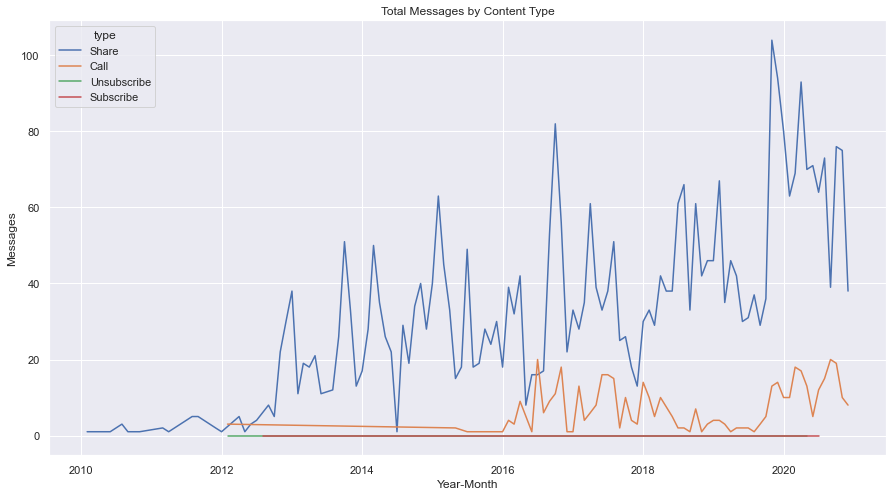

In [24]:
graph_data = data.copy()[data['type'] != 'Generic']

graph_data = graph_data.groupby(['Year-Month', 'type'])['content'].count()
graph_data = graph_data.reset_index()

plt.figure(figsize=(15,8))
g = sns.lineplot(data = graph_data, x = 'Year-Month', y = 'content', hue = 'type')
g = g.set(title = 'Total Messages by Content Type', ylabel = 'Messages')

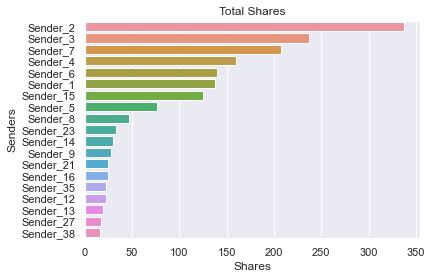

In [26]:
graph_data = data.copy()[data['type'] == 'Share']
graph_data = graph_data.groupby(['sender_name_code'])['content'].count().sort_values(ascending = False).reset_index()[1:20]

g = sns.barplot(data = graph_data, y = 'sender_name_code', x = 'content')
g = g.set(title = 'Total Shares', ylabel = 'Senders', xlabel = "Shares")

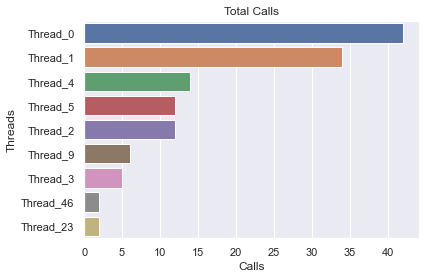

In [25]:
graph_data = data.copy()[data['type'] == 'Call']
graph_data = graph_data[graph_data['sender_name'].isin(top5_friends)]
graph_data = graph_data.groupby('participants_code')['content'].count().sort_values(ascending = False).reset_index()

g = sns.barplot(data = graph_data, y = 'participants_code', x = 'content')
g = g.set(title = 'Total Calls', ylabel = 'Threads', xlabel = 'Calls')

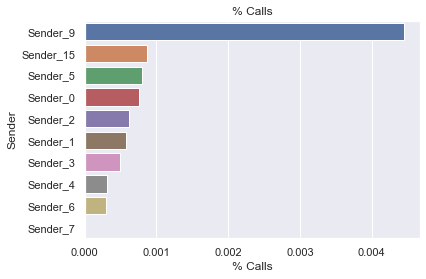

In [31]:
graph_data = data.copy()#[data['type'] == 'Share']
graph_data = graph_data[graph_data['sender_name'].isin(top10_senders)]
graph_data = graph_data.groupby(['sender_name_code', 'type'])['content'].count().reset_index()

graph_data = pd.pivot_table(graph_data, values='content', index=['sender_name_code'],
                            columns=['type'], aggfunc=np.sum).fillna(0)

graph_data['total'] = graph_data.sum(axis = 1)
graph_data['% Calls'] = graph_data['Call'] / graph_data['total']

g = sns.barplot(data = graph_data.sort_values(by = '% Calls', ascending = False).reset_index()[0:10], y = 'sender_name_code', x = '% Calls')
g = g.set(title = '% Calls', ylabel = 'Sender')

### Timeline Trends

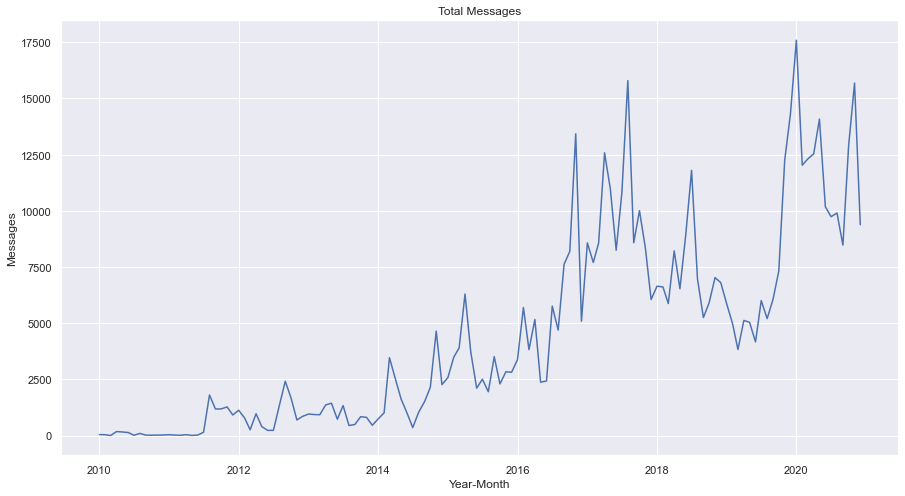

In [32]:
graph_data = data.copy()
graph_data = graph_data.groupby(['Year-Month'])['content'].count()
graph_data = graph_data.reset_index()

plt.figure(figsize=(15,8))
g = sns.lineplot(data = graph_data, x = 'Year-Month', y = 'content')
g = g.set(title = 'Total Messages', ylabel = 'Messages')

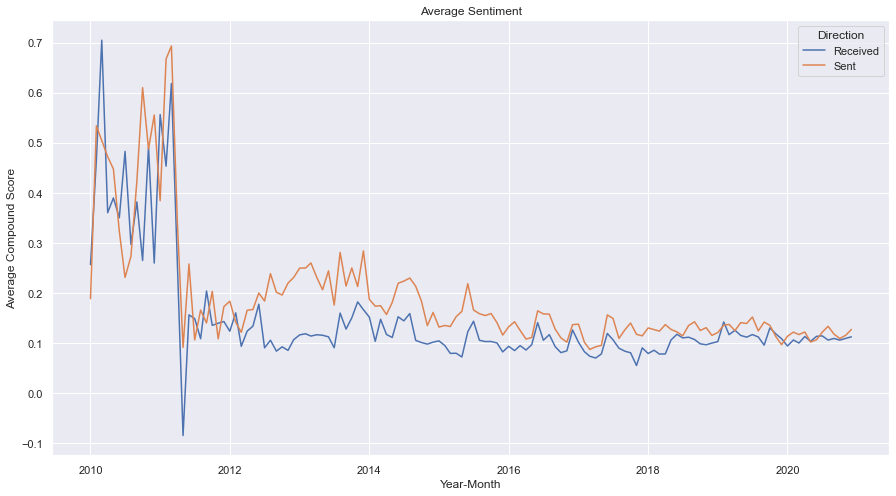

In [33]:
graph_data = data.copy()
graph_data = graph_data.groupby(['Year-Month', 'Direction'])['Compound_Score'].mean()
graph_data = graph_data.reset_index()

plt.figure(figsize=(15,8))
g = sns.lineplot(data = graph_data, x = 'Year-Month', y = 'Compound_Score', hue = 'Direction')
g = g.set(title = 'Average Sentiment', ylabel = 'Average Compound Score')

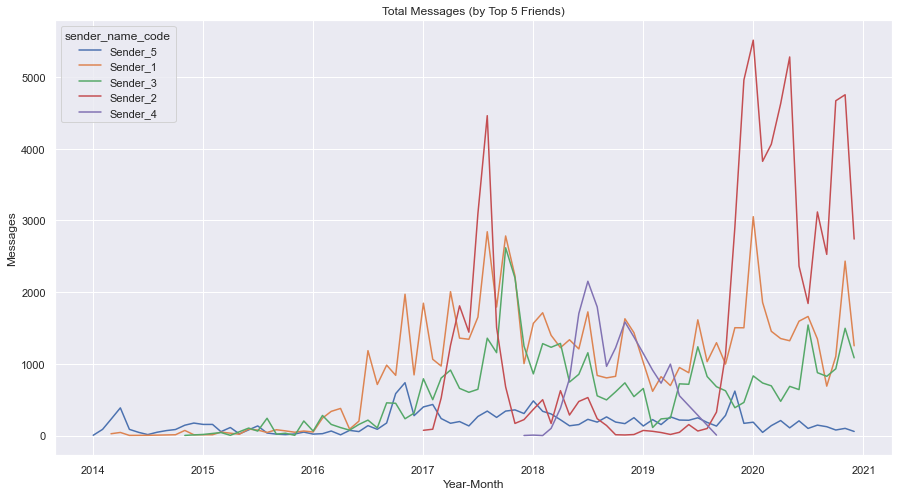

In [34]:
graph_data = data.copy()[data['sender_name'].isin(top5_friends)]

graph_data = graph_data.groupby(['Year-Month', 'sender_name_code'])['content'].count()
graph_data = graph_data.reset_index()

plt.figure(figsize=(15,8))
g = sns.lineplot(data = graph_data, x = 'Year-Month', y = 'content', hue = 'sender_name_code')
g = g.set(title = 'Total Messages (by Top 5 Friends)', ylabel = 'Messages')

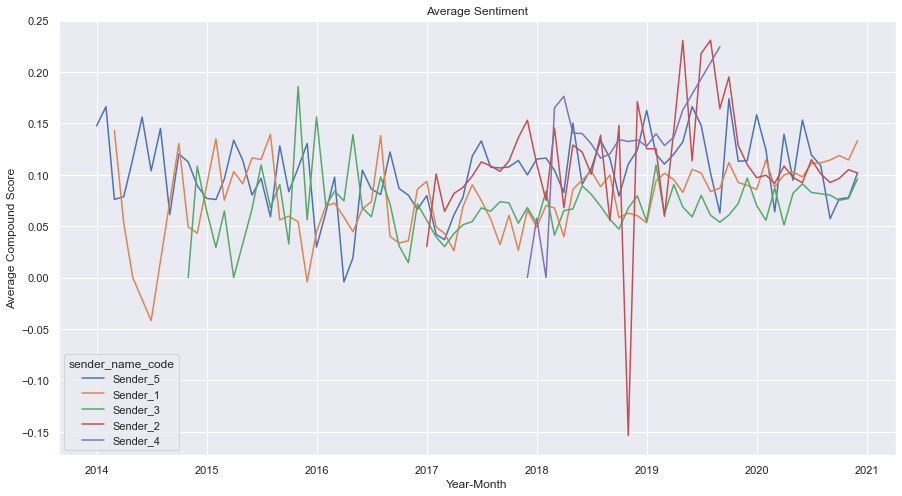

In [35]:
graph_data = data.copy()[data['sender_name'].isin(top5_friends)]
graph_data = graph_data.groupby(['Year-Month', 'sender_name_code'])['Compound_Score'].mean()
graph_data = graph_data.reset_index()

plt.figure(figsize=(15,8))

g = sns.lineplot(data = graph_data, x = 'Year-Month', y = 'Compound_Score', hue = 'sender_name_code')
g = g.set(title = 'Average Sentiment', ylabel = 'Average Compound Score')

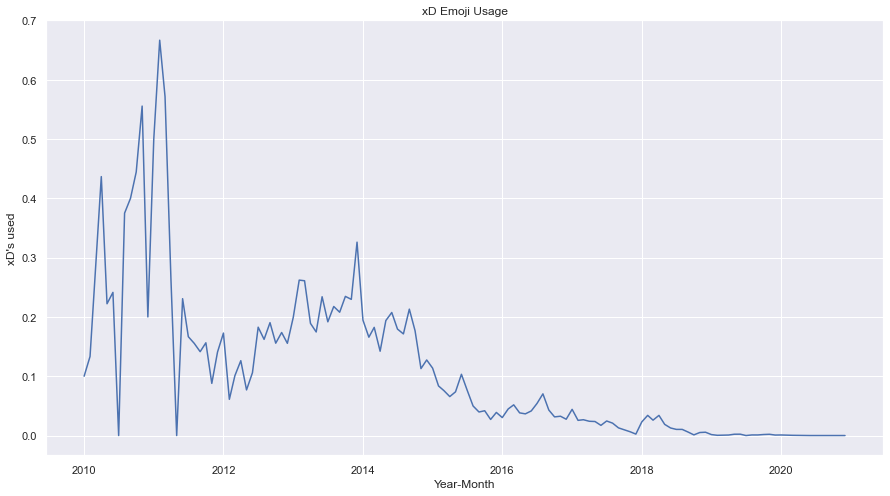

In [36]:
graph_data = data.copy()[data['sender_name_code'] == 'Sender_0']
graph_data = graph_data.groupby(['Year-Month'])['emoji_xD'].mean()
graph_data = graph_data.reset_index()

plt.figure(figsize=(15,8))
g = sns.lineplot(data = graph_data, x = 'Year-Month', y = 'emoji_xD')
g = g.set(title = """xD Emoji Usage""", ylabel = """xD's used""")

### Example Friend Analysis
The following charts focus on analyzing the texts between myself and a college friend, in just our 1-on-1 thread (excluding groupchats). Overall findings show that this friend ("Sender_6") sends more texts in our conversations, but uses fewer emoji and tends to be slightly more positive. We also text more often on weekdays.
#### Interaction over time

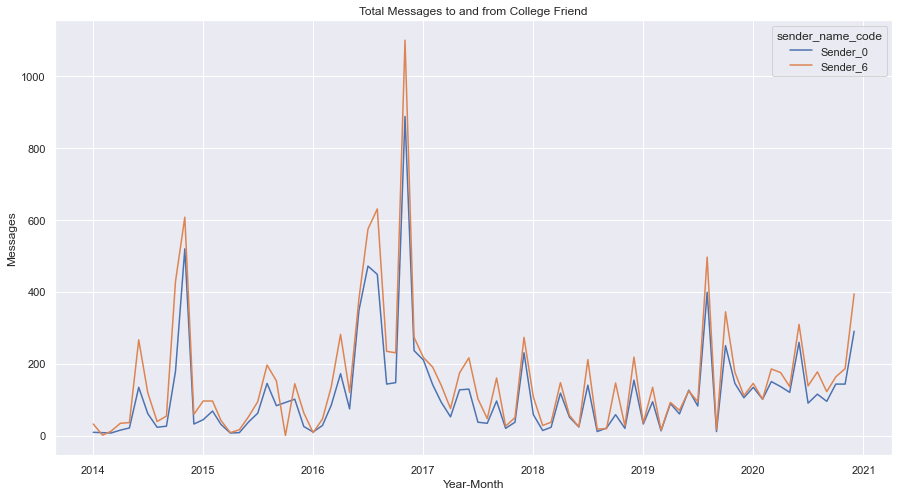

In [37]:
graph_data = data.copy()[data['participants_code'] == "Thread_7"]
graph_data = graph_data.groupby(['Year-Month', 'sender_name_code'])['content'].count()
graph_data = graph_data.reset_index()

plt.figure(figsize=(15,8))
g = sns.lineplot(data = graph_data, x = 'Year-Month', y = 'content', hue = 'sender_name_code')
g = g.set(title = 'Total Messages to and from College Friend', ylabel = 'Messages')

#### Average sentiment over time

[Text(0.5, 1.0, 'Average Sentiment'), Text(0, 0.5, 'Average Compound Score')]

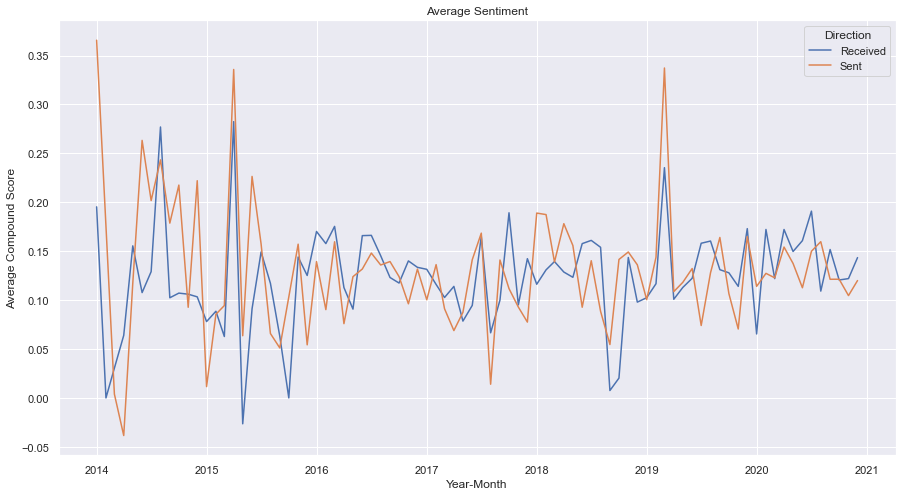

In [30]:
graph_data = data.copy()[data['participants_code'] == "Thread_7"]
graph_data = graph_data.groupby(['Year-Month', 'Direction'])['Compound_Score'].mean()
graph_data = graph_data.reset_index()

plt.figure(figsize=(15,8))

g = sns.lineplot(data = graph_data, x = 'Year-Month', y = 'Compound_Score', hue = 'Direction')
g = g.set(title = 'Average Sentiment', ylabel = 'Average Compound Score')

Here are a few examples of top most positive and most negative messages:

In [52]:
pd.set_option('display.max_colwidth', None)
graph_data = data.copy()[data['participants_code'] == "Thread_7"]
graph_data = graph_data[graph_data['Text_length'] > 50].sort_values('Positive_Score', ascending = False)

# Top 5 most positive messages
graph_data[['Date', 'sender_name_code', 'content', 'Compound_Score', 'Positive_Score', 'Negative_Score', 'Neutral_Score']].head()

,Date,sender_name_code,content,Compound_Score,Positive_Score,Negative_Score,Neutral_Score
381711,2019-08-25,Sender_0,If you're so certain that you're into them you have to do it,0.2732,1.000,0.0,0.000
379801,2020-02-26,Sender_0,Or are they all just curious about her because it's you,0.3182,1.000,0.0,0.000
388026,2017-01-05,Sender_6,that was so fun grace was hanging out with all my friends,0.8481,0.902,0.0,0.098
379401,2020-04-03,Sender_6,The weather here is unbelievable its like clear and 65Â°,0.7096,0.873,0.0,0.127
392805,2016-07-26,Sender_0,"i was having a /great/ time, super happy, and then this other happy thing happened",0.9468,0.837,0.0,0.163


In [53]:
pd.set_option('display.max_colwidth', None)
graph_data = data.copy()[data['participants_code'] == "Thread_7"]
graph_data = graph_data[graph_data['Text_length'] > 50].sort_values('Negative_Score', ascending = False)

# Top 5 most negative messages
graph_data[['Date', 'sender_name_code', 'content', 'Compound_Score', 'Positive_Score', 'Negative_Score', 'Neutral_Score']].head()

,Date,sender_name_code,content,Compound_Score,Positive_Score,Negative_Score,Neutral_Score
384038,2018-10-03,Sender_6,So its just been so tough for me and now im stuck in indecisiveness,-0.5859,0.000,0.853,0.147
389565,2016-11-17,Sender_0,It's just infuriating to me bc i know it's fake but idk how,-0.7845,0.000,0.798,0.202
389480,2016-11-22,Sender_6,Idk i just want you to not be depressed about all this,-0.5267,0.217,0.783,0.000
391611,2016-08-27,Sender_0,Alex dragged me to anchorman 2 which wasn't horrific,-0.6808,0.000,0.737,0.263
394809,2016-04-07,Sender_0,"anyway we were losing badly, esp me, and then had a turnaround and killed it",-0.8807,0.000,0.718,0.282


#### Total messages
My friend sent both more total messages and more total characters.

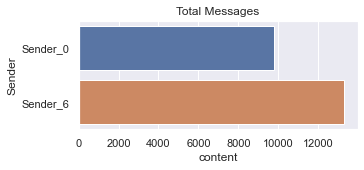

In [38]:
graph_data = data.copy()[data['participants_code'] == "Thread_7"]
graph_data = graph_data.groupby(['sender_name_code'])['content'].count()
graph_data = graph_data.reset_index()

plt.figure(figsize=(5, 2))
g = sns.barplot(data = graph_data, y = 'sender_name_code', x = 'content')
g = g.set(title = 'Total Messages', ylabel = 'Sender')

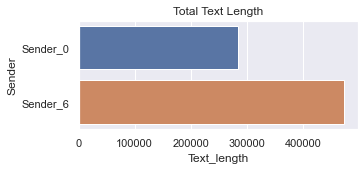

In [39]:
graph_data = data.copy()[data['participants_code'] == "Thread_7"]
graph_data = graph_data.groupby(['sender_name_code'])['Text_length'].sum()
graph_data = graph_data.reset_index()

plt.figure(figsize=(5, 2))
g = sns.barplot(data = graph_data, y = 'sender_name_code', x = 'Text_length')
g = g.set(title = 'Total Text Length', ylabel = 'Sender')

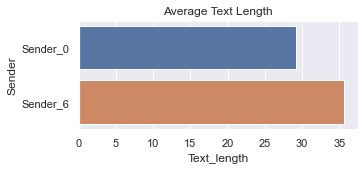

In [40]:
graph_data = data.copy()[data['participants_code'] == "Thread_7"]
graph_data = graph_data.groupby(['sender_name_code'])['Text_length'].mean()
graph_data = graph_data.reset_index()

plt.figure(figsize=(5, 2))
g = sns.barplot(data = graph_data, y = 'sender_name_code', x = 'Text_length')
g = g.set(title = 'Average Text Length', ylabel = 'Sender')

#### Emoji and profanity
My friend sent fewer emoji and less profanity overall.

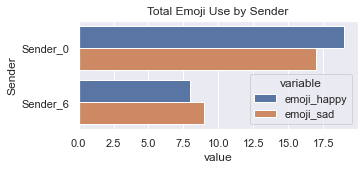

In [68]:
graph_data1 = data.copy()[data['participants_code'] == "Thread_7"]
graph_data1 = graph_data1.groupby(['sender_name_code'])['emoji_happy'].sum()

graph_data2 = data.copy()[data['participants_code'] == "Thread_7"]
graph_data2 = graph_data2.groupby(['sender_name_code'])['emoji_sad'].sum()

graph_data = pd.concat([graph_data1, graph_data2], axis = 1).reset_index()
graph_data = pd.melt(graph_data, id_vars = ['sender_name_code'], value_vars = ['emoji_happy', 'emoji_sad'])

plt.figure(figsize=(5, 2))
g = sns.barplot(data = graph_data, y = 'sender_name_code', x = 'value', hue = 'variable')
g = g.set(title = 'Total Emoji Use by Sender', ylabel = 'Sender')

[Text(0.5, 1.0, 'Total Messages by Day of Week'),
 Text(0, 0.5, 'Messages'),
 Text(0.5, 0, 'Day of Week (0 = Monday)')]

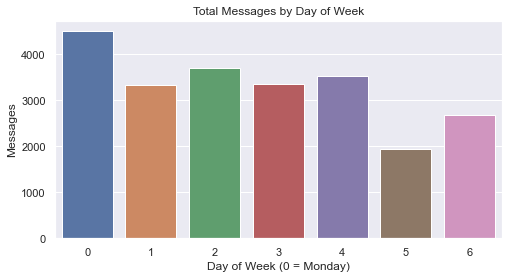

In [38]:
graph_data = data.copy()[data['participants_code'] == "Thread_7"]
graph_data['Day_of_Week'] = graph_data['Datetime'].dt.dayofweek
graph_data = graph_data.groupby(['Day_of_Week'])['content'].count()
graph_data = graph_data.reset_index()

plt.figure(figsize=(8, 4))
g = sns.barplot(data = graph_data, y = 'content', x = 'Day_of_Week')
g = g.set(title = 'Total Messages by Day of Week', ylabel = 'Messages', xlabel = 'Day of Week (0 = Monday)')

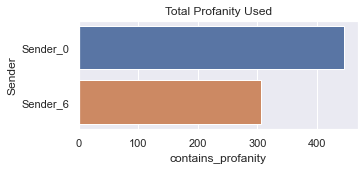

In [69]:
graph_data = data.copy()[data['participants_code'] == "Thread_7"]
graph_data = graph_data.groupby(['sender_name_code'])['contains_profanity'].sum()
graph_data = graph_data.reset_index()

plt.figure(figsize=(5, 2))
g = sns.barplot(data = graph_data, y = 'sender_name_code', x = 'contains_profanity')
g = g.set(title = 'Total Profanity Used', ylabel = 'Sender')

## Aggregate Analyses

### Sender Master Table
So far, most of the data has been at the day/month grain. Instead, it may be helpful to aggregate the data at the sender level to identify characteristics and see if there are any non-obvious underlying correlations.

In [40]:
senders = data.groupby('sender_name').agg({'content': 'count',
                                'Text_length': 'sum',
                                'Compound_Score': 'mean',
                                'sticker': 'count',
                                'participants': 'nunique',
                                'photos': 'count',
                                'share': 'count',
                                'reactions': 'count',
                                'files': 'count',
                                'call_duration': 'count',
                                'gifs': 'count',
                                'audio_files': 'count',
                                'videos': 'count',
                                'Date': 'nunique',
                                'Datetime': 'max',
                                'time_diff': 'max'})

senders['%_calls'] = senders['call_duration'] / senders['content']
senders['%_stickers'] = senders['sticker'] / senders['content']
senders['%_photos'] = senders['photos'] / senders['content']
senders['%_shares'] = senders['share'] / senders['content']
senders['%_gifs'] = senders['gifs'] / senders['content']
senders['%_videos'] = senders['videos'] / senders['content']
senders['%_reacts'] = senders['reactions'] / senders['content']
senders['%_audio'] = senders['audio_files'] / senders['content']
senders['texts_per_day'] = senders['content'] / senders['Date']

senders.rename(columns={'content': 'total_messages',
                    'Text_length': 'total_characters',
                    'participants': 'total_threads',
                    'Compound_Score': 'avg_sentiment',
                    'call_duration': 'total_calls',
                    'Date': 'days',
                    'time_diff': 'longest_gap'}, inplace = True)

# senders.drop(columns = ['sticker', 'photos', 'share', 'reactions', 'files','gifs', 'audio_files', 'videos'], inplace = True)

In [41]:
senders = senders[senders['total_messages'] > 1000]
senders_sub = senders[['%_calls', '%_stickers', '%_photos', '%_shares', '%_gifs', '%_videos', '%_reacts',
                       '%_audio', 'texts_per_day', 'avg_sentiment']]

[Text(0.5, 1.0, 'Correlation Matrix')]

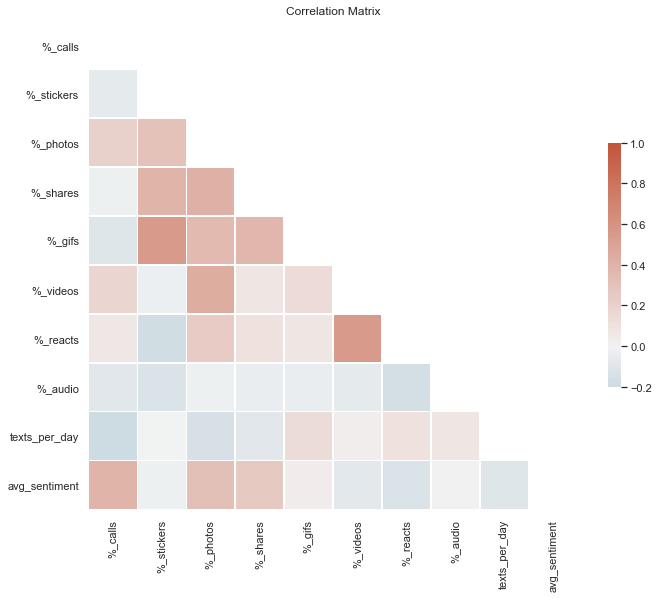

In [42]:
from string import ascii_letters

sns.set_theme(style="white")

# Compute the correlation matrix
corr = senders_sub.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
g = sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
g.set(title = "Correlation Matrix")

## NLP
Leveraging well-known NLP frameworks to extract additional insights.

### NGrams
Ngrams gives us a chance to identify common word pairings.

In [57]:
import re
from nltk.util import ngrams

data['content_without_stopwords'] = data['content_without_stopwords'].fillna('')
tokens = nltk.word_tokenize(" ".join(data['content_without_stopwords']))
output = list(ngrams(tokens, 2))

word_fd = nltk.FreqDist(tokens)
bigram_fd = nltk.FreqDist(ngrams(tokens, 2))

bigram_fd.most_common(20)

[(('gon', 'na'), 5133),
 (('wan', 'na'), 3580),
 (('feel', 'like'), 2031),
 (('got', 'ta'), 1580),
 (('im', 'sorry'), 1289),
 (('im', 'going'), 1270),
 (('sounds', 'like'), 1093),
 (('let', 'know'), 1015),
 (('im', 'gon'), 989),
 (('im', 'sure'), 913),
 (('haha', 'yeah'), 906),
 (('sounds', 'good'), 859),
 (('looks', 'like'), 822),
 (('im', 'glad'), 763),
 (('last', 'night'), 759),
 (('makes', 'sense'), 744),
 (('haha', 'im'), 711),
 (('make', 'sure'), 664),
 (('na', 'go'), 651),
 (('meow', 'meow'), 628)]

### TF-IDF by Sender
Using a version of TF-IDF (created by Maarten Grootendorst [here](https://github.com/MaartenGr/soan/blob/master/notebooks/soan.ipynb)) I created a function to identify words in each thread that were unique to a specific person. For example, my friend Sender_6 and I had the following unique words:

In [58]:
from sklearn.feature_extraction.text import CountVectorizer

def get_tfidf_for_thread(thread, name_code, word_min = 20, n_words = 30):
    tfidf_data = data.copy()[data['participants_code'] == thread][['sender_name_code', 'content_clean']]
    
    final_words = pd.DataFrame()
    for sender in tfidf_data['sender_name_code'].unique():
        sender_texts = tfidf_data[tfidf_data['sender_name_code'] == sender]

        vectorizer = CountVectorizer()
        X = vectorizer.fit_transform(sender_texts['content_clean'])
        sender_words = pd.DataFrame(X.toarray(), columns = vectorizer.get_feature_names()).T.sum(axis = 1)
        sender_words.name = sender

        final_words = pd.concat([final_words, sender_words], axis = 1)

    n_users = len(final_words.columns)
    for user in final_words.columns:
        word_used_by_user = final_words[user]
        word_used_total = final_words.sum(axis = 1)
        total_words = final_words.iloc[:, 0:n_users].sum().sum()
        total_user_words = final_words[user].sum()

        final_words["TF-IDF_" + user] = word_used_by_user / word_used_total * total_words / total_user_words
    
    final_list = final_words[final_words.iloc[:, 0:n_words].sum(axis = 1) > word_min]
    return(final_list.sort_values(['TF-IDF_' + name_code], ascending = False).head(n_words))

Picking on my example college friend again, here's a selection of my friend's (Sender_6's) unique words, as well as mine.

In [59]:
data['content_clean'] = data['content_clean'].fillna('')
get_tfidf_for_thread("Thread_7", "Sender_6", n_words = 10) # My friend's most common words

,Sender_6,Sender_0,TF-IDF_Sender_6,TF-IDF_Sender_0
director,19.0,NaN,1.620370,NaN
aw,26.0,NaN,1.620370,NaN
liya,21.0,NaN,1.620370,NaN
ya,67.0,1.0,1.596541,0.037530
aliya,40.0,1.0,1.580848,0.061341
lol,357.0,12.0,1.567675,0.084582
based,27.0,1.0,1.562499,0.088353
yep,46.0,2.0,1.552854,0.105420
thinks,21.0,1.0,1.546716,0.110926
joys,20.0,1.0,1.543209,0.115864


In [60]:
get_tfidf_for_thread("Thread_7", "Sender_0", n_words = 10) # My most most common words

,Sender_6,Sender_0,TF-IDF_Sender_6,TF-IDF_Sender_0
yup,NaN,74.0,NaN,2.611942
yeahh,NaN,30.0,NaN,2.611942
five,NaN,19.0,NaN,2.611942
defs,NaN,19.0,NaN,2.611942
ahh,NaN,33.0,NaN,2.611942
xd,17.0,380.0,0.069386,2.499659
uhh,1.0,17.0,0.090021,2.454559
min,2.0,24.0,0.124644,2.399520
mmm,3.0,29.0,0.151910,2.355889
bc,11.0,89.0,0.178241,2.320493


I obviously use a lot more slang and text-speak, while my friend call me by name and uses "lol" much more often.
### Profanity by Thread
Testing to see if my profanity levels change depending on who I'm talking to. Surprise, surprise, they do!

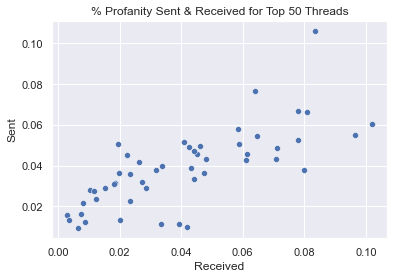

In [70]:
profanity_by_thread = data[data.participants.isin(top50_threads)]
profanity_by_thread = profanity_by_thread.groupby(['participants_code', 'Direction'])['contains_profanity'].mean()
profanity_by_thread = profanity_by_thread.reset_index()

profanity_by_thread = pd.pivot_table(profanity_by_thread, values='contains_profanity', 
                                     index=['participants_code'], columns=['Direction'], aggfunc=np.sum).fillna(0)

g = sns.scatterplot(data = profanity_by_thread, x = 'Received', y = 'Sent')
g = g.set_title ("% Profanity Sent & Received for Top 50 Threads")

### Top2Vec
[Top2Vec](https://towardsdatascience.com/top2vec-new-way-of-topic-modelling-bea165eeac4a) is a package meant to extract topics from a given block of text. After experimenting a bit, I realized that individual messages aren't long enough to register specific subjects. Instead, I create new documents by grouping all the texts from a thread per day together (making the assumption that within that thread, we talk about just one thing all day, which is a little unlikely). 

Additionally, I ran this first on Thread_7, which is my example friend from above, but the results didn't tell a particularly great story. On a hunch, I ran this on Thread_0, my longest thread, instead. The topics returned were relatively comprehensive and legitimate!

In [ ]:
from top2vec import Top2Vec

In [118]:
thread = "Thread_0"
thread_messages = data[(data['participants_code'] == thread) & (data['type'] == "Generic")]
final_messages = pd.DataFrame()
for day in thread_messages['Date'].unique():
    all_texts = thread_messages[thread_messages['Date'] == pd.to_datetime(day)]['content_without_stopwords'].fillna('')
    one_text = pd.Series([" ".join(all_texts)])
    final_messages = pd.concat([final_messages, one_text])
    
final_messages.columns = ['text']

In [119]:
texting_model = Top2Vec(documents=list(final_messages['text']), speed="learn", workers=8)

2021-01-08 12:34:42,367 - top2vec - INFO - Pre-processing documents for training
2021-01-08 12:34:44,022 - top2vec - INFO - Creating joint document/word embedding
2021-01-08 12:35:15,599 - top2vec - INFO - Creating lower dimension embedding of documents
2021-01-08 12:35:19,496 - top2vec - INFO - Finding dense areas of documents
2021-01-08 12:35:19,552 - top2vec - INFO - Finding topics


In [120]:
texting_model.get_num_topics()

7

In [121]:
topic_words, word_scores, topic_nums = texting_model.get_topics(7)

In [124]:
topic_words[[0, 3, 4, 5, 6]] # Redacting several topics since they contain names

array([['trip', 'flight', 'fun', 'jk', 'night', 'lmao', 'guys', 'flying',
        'haha', 'brunch', 'airport', 'fly', 'ride', 'wexxre', 'were',
        'pretty', 'lol', 'hotel', 'happening', 'meet', 'xfxx', 'go',
        'hanging', 'xfx', 'kk', 'sf', 'gonna', 'amazing', 'sunday',
        'ahh', 'headed', 'taking', 'nice', 'come', 'plane', 'chicago',
        'yeah', 'next', 'hope', 'tho', 'def', 'let', 'weekend', 'leave',
        'staying', 'nope', 'land', 'actually', 'lmfao', 'cute'],
       ['analytics', 'project', 'tech', 'projects', 'career',
        'experience', 'company', 'code', 'apply', 'interviews',
        'manager', 'technical', 'job', 'technically', 'interview',
        'write', 'team', 'strava', 'learning', 'work', 'etc', 'director',
        'learn', 'skills', 'issue', 'questions', 'consulting', 'people',
        'promotion', 'year', 'wmp', 'sense', 'mba', 'whatxxs', 'classes',
        'doesnt', 'youxxve', 'it', 'think', 'boss', 'data', 'lot',
        'says', 'interesting'

Making sense of these helps tell a great story - there's a topic on traveling (I used to be a consultant), on careers, on hiking (we planned a hiking trip to Zion National Park), on politics, and on working out!